In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
from symspellpy import SymSpell, Verbosity
import numpy as np
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import model_selection

from yellowbrick.cluster import KElbowVisualizer
from kmodes.kmodes import KModes


In [286]:
from nltk.stem import SnowballStemmer #more info here: https://www.geeksforgeeks.org/snowball-stemmer-nlp/

stemmer = SnowballStemmer('english')

def replace(t): #Function for catching what the stemmer misses to further reduce the number of categories (so far only for optimized for base notes) 

    if "amber" in t:
        t = "amber"
    if "cash" in t:
        t = "cashmere"
    if "flo" in t:
        t = "floral"
    if "ced" in t:
        t = "cedar"
    if "mu" in t:
        t = "musk"
    if "leather" in t:
        t = "leather"
    if "lil" in t:
        t = "lily"
    if "lacton" in t:
        t = "lacton"
    if "labda" in t:
        t = "labdanum"
    if "patch" in t:
        t = "patchouli"
    if "vanil" in t:
        t = "vanilla"
    if "oud" in t:
        t = "oud"
    if "oliv" in t:
        t = "olive"
    if "sand" in t:
        t = "sandalwood"
    if "wood" in t[:4]:
        t = "wood"
#    elif "wood" in t:
#        t = "wood"

    return t
            

class StemmedCountVectorizer(CountVectorizer): #Builds ontop of sklearn:s CountVectorizer, documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    
     def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(replace(w)) for w in analyzer(doc)]) 
    
#    def build_tokenizer(self):
#        tokenize = super().build_tokenizer()
#        return lambda doc: list(replace(tokenize(doc)))



In [425]:
scaler = StandardScaler()
mlb = LabelEncoder()
pca = PCA(n_components=2)

df_original = pd.read_csv("data/noon_perfumes_dataset.csv", index_col=0)
df = df_original.copy(deep=True)

### Pre-proc

In [274]:
#CROP IRRELEVANT COLUMNS
irrelevant_cols = ['item_rating', 'noon','seller_rating','num_seller_ratings','']
relevant_cols = ['brand','name','department']
df_cropped = df.drop_duplicates(subset=relevant_cols)

In [275]:
#CONVERT PRICE TO REAL MONEYS
df.old_price = df_original.old_price*0.24
df.new_price = df_original.new_price*0.24

In [276]:
#REMOVE THE CHILD
df.drop(index=df[df.department == 'Kids Unisex'].index, inplace=True)

In [277]:
#REMOVE THE OIL
df.drop(index=df[df.concentration == 'Oil'].index, inplace=True)

In [278]:
#REMOVE THE PDT
df.drop(index=df[df.concentration == 'PDT'].index, inplace=True)

In [294]:
notes = df[['base_note', 'middle_note']].values
base = df['base_note'].values
scents_clean = df['scents'].apply(lambda y: y.lower()).values

In [295]:
def text_clean(text_array):
    text_list = []
    for text_pair in text_array:
        pair = []
        for text in text_pair:
            text = text.lower().replace(" and", ",") #join base_note and middle_note strings, lowercase everything and replace "and" with a comma
            text = re.sub(r"\b\,\b", ", ", text)
            text = re.sub(r"\b\,|\B\,|-", "", text)
            pair.append(text)
        text_list.append((" ").join(pair))
    return text_list

In [296]:
notes_clean = text_clean(notes)
base_clean = text_clean(base)

In [282]:
df_not_noon = pd.read_csv("data/perfume.csv", sep=",")
df_not_noon = df_not_noon[(df_not_noon.votes > 100)]
all_long = np.array(df_not_noon[['longevity_poor', 'longevity_weak', 'longevity_moderate','longevity_long', 'longevity_very_long']])
df_not_noon = df_not_noon[(sum(all_long.T) > 3)]

longevity = np.array(df_not_noon[['longevity_poor', 'longevity_weak', 'longevity_moderate','longevity_long', 'longevity_very_long']])
date = df_not_noon.date

mddf = df_not_noon[['rating_score','date', 'votes','gender','longevity_poor', 'longevity_weak', 'longevity_moderate','longevity_long', 'longevity_very_long']]
mddf.gender = mlb.fit_transform(mddf.gender)


C:\Users\Sebastian\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Kmodes on Daniels code


In [450]:
df = df[(df["department"] != "Kids Unisex")] #We remove kids unisex because it has only one datapoint
df.drop(index=df[df.concentration == 'PDT'].index, inplace=True)
df.drop(index=df[df.concentration == 'Oil'].index, inplace=True)
#Labels
gender = df["department"].apply(lambda y: 'Men' if y == 'Unisex' else y)
#Features
base_note = df["base_note"].values
middle_note = df["middle_note"].values
scents = df["scents"].values

In [452]:
vect_base = StemmedCountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine']) #vectorizer for base notes
vect_middle = StemmedCountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine']) #vectorizer for middle notes
vect_scents = StemmedCountVectorizer(stop_words = ['and']) #vectorizer for scents

X1 = vect_base.fit_transform(base_note)#Base notes, 902 x 283 binary matrix – 1 for present, 0 for absent for each perfume
X2 = vect_middle.fit_transform(middle_note) #Middle notes, 902 x 412 binary matrix
X3 = vect_scents.fit_transform(scents)#Scents, 902 x 16 binary matrix

vecnotes = StemmedCountVectorizer(min_df=2,stop_words=['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vecscents = StemmedCountVectorizer(stop_words=['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])

X4 = vecnotes.fit_transform(notes_clean)
X5 = vecscents.fit_transform(scents_clean)
X6 = np.hstack((X4.todense(), X5.todense()))
X6.shape

(997, 359)

In [373]:
vecnotes.get_feature_names()

['absolut',
 'accord',
 'african',
 'agarwood',
 'akigalawood',
 'aldehyd',
 'allianc',
 'almond',
 'amarylli',
 'amber',
 'ambregri',
 'ambroxan',
 'american',
 'an',
 'animalist',
 'anis',
 'appl',
 'apricot',
 'aroma',
 'aromat',
 'atlas',
 'australian',
 'balsam',
 'bamboo',
 'basil',
 'bean',
 'beeswax',
 'benzoin',
 'bergamot',
 'berri',
 'birch',
 'black',
 'blackberri',
 'blackcurr',
 'blond',
 'blood',
 'blossom',
 'blue',
 'bluebel',
 'bourbon',
 'bran',
 'brazilian',
 'bulgarian',
 'burnt',
 'butterfli',
 'cacao',
 'cactus',
 'candi',
 'caramel',
 'caraway',
 'cardamom',
 'carnat',
 'carrot',
 'casablanca',
 'cashmer',
 'cassi',
 'cassia',
 'cedar',
 'centifolia',
 'ceylon',
 'chamomil',
 'champaca',
 'charact',
 'cheroke',
 'cherri',
 'chestnut',
 'chill',
 'chines',
 'chocol',
 'cinnamon',
 'cistus',
 'citric',
 'citrus',
 'civet',
 'clari',
 'clean',
 'clementin',
 'clove',
 'cocoa',
 'coconut',
 'coffe',
 'coral',
 'coriand',
 'cotton',
 'coumarin',
 'cranberri',
 'cream

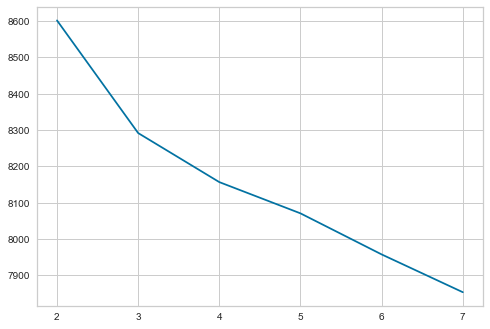

In [352]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X1, gender, test_size=0.33)
pricelist = []
for i in range(2,8):
    kmode = KModes(n_clusters=i, init = "random", n_init = 10)
    kmode.fit(X6)
    pricelist.append([i, min(kmode.epoch_costs_)])


prices = np.array(pricelist)
plt.plot(prices[:,0], prices[:,1])
#clusters = kmode.fit_predict(X123)

In [370]:
kmode = KModes(n_clusters=2, max_iter=200, init = "random", n_init = 15)
preds = kmode.fit_predict(X5.todense())

In [401]:
from collections import Counter
print((vecscents.vocabulary_, sum(X5.todense())))

({'wood': 15, 'floral': 4, 'arabian': 0, 'spici': 12, 'orient': 9, 'fruiti': 6, 'fresh': 5, 'citrus': 2, 'vanilla': 14, 'musk': 8, 'sweet': 13, 'aromat': 1, 'clean': 3, 'jasmin': 7, 'rose': 10, 'sandalwood': 11}, matrix([[ 75,  16,  93,   1, 315,  43,  77,   4,  10,  35,   2,   2, 114,
           3,  24, 196]], dtype=int64))


In [439]:
dict(zip(vect_scents.get_feature_names(), sum(X3.toarray())))

dict_values([75, 16, 93, 1, 315, 43, 77, 4, 10, 35, 2, 2, 114, 3, 24, 196])

X = correlation with gender
Y = dict(zip(vect_scents.get_feature_names(), sum(X3.toarray()))).values()

In [453]:
len(gender), len(X5.todense())

(997, 997)

In [471]:
scent_cluster = pd.DataFrame(X5.todense())
#scent_cluster['clusters'] = preds

scent_cluster['gender'] = mlb.fit_transform(gender)
X = scent_cluster.corr().iloc[-1][:-1]
Y = dict(zip(vect_scents.get_feature_names(), sum(X3.toarray()))).values()


In [477]:
vec = CountVectorizer()
out = vec.fit_transform(gender)

In [479]:
out.todense()

matrix([[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [1, 0],
        [1, 0]], dtype=int64)

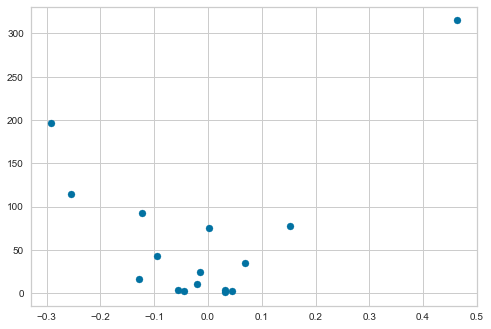

In [473]:
plt.scatter(X, Y)

In [371]:
df_corr = df.copy()
df_corr.drop(['department', 'scents', 'base_note', 'middle_note', 'seller','num_seller_ratings'], axis=1, inplace=True)
df_corr['clusters'] = preds
df_corr['brand'] = mlb.fit_transform(df.brand)
df_corr['name'] = mlb.fit_transform(df.name)
df_corr['gender'] = mlb.fit_transform(gender)
df_corr['concentration'] = mlb.fit_transform(df.concentration)

In [372]:
df_corr.corr()

,brand,name,old_price,new_price,ml,concentration,item_rating,seller_rating,clusters,gender
brand,1.000000,0.108810,-0.036838,-0.001445,-0.035067,0.051141,0.044437,0.010865,-0.063129,-0.014706
name,0.108810,1.000000,-0.028168,-0.015708,-0.032864,-0.124253,0.028500,-0.009596,0.090804,0.086168
old_price,-0.036838,-0.028168,1.000000,0.841810,0.129848,-0.210091,0.072514,-0.091528,0.091654,0.116519
new_price,-0.001445,-0.015708,0.841810,1.000000,0.138367,-0.246922,0.101961,-0.010561,0.068533,0.118699
ml,-0.035067,-0.032864,0.129848,0.138367,1.000000,0.254131,-0.034914,0.026195,-0.167099,-0.272029
concentration,0.051141,-0.124253,-0.210091,-0.246922,0.254131,1.000000,-0.121972,-0.031854,-0.251883,-0.490587
item_rating,0.044437,0.028500,0.072514,0.101961,-0.034914,-0.121972,1.000000,-0.036694,0.039754,0.117296
seller_rating,0.010865,-0.009596,-0.091528,-0.010561,0.026195,-0.031854,-0.036694,1.000000,-0.063844,-0.065513
clusters,-0.063129,0.090804,0.091654,0.068533,-0.167099,-0.251883,0.039754,-0.063844,1.000000,0.463419
gender,-0.014706,0.086168,0.116519,0.118699,-0.272029,-0.490587,0.117296,-0.065513,0.463419,1.000000


### Attempts at K-Meanss

In [ ]:
def convert_ratings(array):
    copy = array.copy()
    div = sum(array.T)
    for i in range(0,5):
        copy[:,i] = copy[:,i]*(i+1)
    return sum(copy.T)/div
    

long_vote = convert_ratings(longevity)      
#long_vote = scaler.fit_transform(long_vote.reshape(-1,1))

In [ ]:
long_vote = scaler.fit_transform(long_vote.reshape(-1,1))
ratings = scaler.fit_transform(ratings.values.reshape(-1,1))
#date_scaled = scaler.fit_transform(np.array(date).reshape(-1,1))

long_rating = np.hstack((long_vote, ratings))


In [ ]:
sorting = (df_not_noon.date > 2000)
kmeans_not_noon = KMeans(n_clusters=1).fit(long_rating)

plt.figure(figsize=(20,20))
plt.scatter(long_rating[:,0][sorting], long_rating[:,1][sorting], alpha=0.5, cmap='spring', c=kmeans_not_noon.labels_[sorting])
plt.scatter(kmeans_not_noon.cluster_centers_[:,0], kmeans_not_noon.cluster_centers_[:,1])
#No point in clustering this - 1 (perfect) normal distribution

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(long_rating)        # Fit the data to the visualizer
visualizer.show();

In [ ]:
df_not_noon.head()